In [2]:
print("Hello")

Hello


## First

In [5]:
import os
import torch

REPO_URL = "https://github.com/thenileshmishra/AS-RoPE.git"
REPO_DIR = "/content/AS-RoPE"

if not os.path.exists(REPO_DIR):
    !git clone {REPO_URL} {REPO_DIR}
%cd {REPO_DIR}
!git pull

%pip install -q -r requirements.txt

# Verify critical files exist
!ls -la as_rope.py model.py rope.py train.py eval_perplexity.py scaled_rope.py

print('cuda_available=', torch.cuda.is_available())
if torch.cuda.is_available():
    print('gpu=', torch.cuda.get_device_name(0))

/content/AS-RoPE
remote: Enumerating objects: 6, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 4 (delta 2), reused 4 (delta 2), pack-reused 0 (from 0)
Unpacking objects: 100% (4/4), 3.36 KiB | 3.36 MiB/s, done.
From https://github.com/thenileshmishra/AS-RoPE
   628f2b8..0d18e6c  main       -> origin/main
Updating 628f2b8..0d18e6c
Fast-forward
 .gitignore                      |   1 +
 run_all_positional_encodings.py | 223 ++++++++++++++++++++++++++++++++++++++++
 2 files changed, 224 insertions(+)
 create mode 100644 run_all_positional_encodings.py
-rw-r--r-- 1 root root 2874 Feb 24 05:03 as_rope.py
-rw-r--r-- 1 root root 5907 Feb 24 05:03 eval_perplexity.py
-rw-r--r-- 1 root root 7100 Feb 24 05:03 model.py
-rw-r--r-- 1 root root 2744 Feb 24 05:03 rope.py
-rw-r--r-- 1 root root 2056 Feb 24 05:03 scaled_rope.py
-rw-r--r-- 1 root root 8253 Feb 24 05:03 train.py
cuda_available= True
gpu= NVIDIA A100-SXM4-40GB


In [8]:
!python train.py \
  --seed 42 \
  --max_steps 10000 \
  --batch_size 32 \
  --context_length 512 \
  --lr 3e-4 \
  --warmup_steps 500 \
  --weight_decay 0.1 \
  --log_interval 200 \
  --save_interval 1000 \
  --checkpoint_path checkpoint_rope.pt \
  --metrics_path logs/rope_metrics.csv

tokenizer_config.json: 100% 26.0/26.0 [00:00<00:00, 110kB/s]
vocab.json: 100% 1.04M/1.04M [00:00<00:00, 1.40MB/s]
merges.txt: 100% 456k/456k [00:00<00:00, 1.08MB/s]
tokenizer.json: 100% 1.36M/1.36M [00:00<00:00, 11.1MB/s]
README.md: 10.5kB [00:00, 26.1MB/s]
wikitext-2-raw-v1/test-00000-of-00001.pa(…): 100% 733k/733k [00:01<00:00, 584kB/s]  
wikitext-2-raw-v1/train-00000-of-00001.p(…): 100% 6.36M/6.36M [00:00<00:00, 10.9MB/s]
wikitext-2-raw-v1/validation-00000-of-00(…): 100% 657k/657k [00:00<00:00, 1.21MB/s] 
Generating test split: 100% 4358/4358 [00:00<00:00, 154908.83 examples/s]
Generating train split: 100% 36718/36718 [00:00<00:00, 830904.32 examples/s]
Generating validation split: 100% 3760/3760 [00:00<00:00, 679766.51 examples/s]
Token indices sequence length is longer than the specified maximum sequence length for this model (2415650 > 1024). Running this sequence through the model will result in indexing errors
Training on cuda
Parameters: 16.02M
use_as_rope=False
step     1 | t

In [10]:
!python train.py \
  --seed 42 \
  --max_steps 10000 \
  --batch_size 32 \
  --context_length 512 \
  --lr 3e-4 \
  --warmup_steps 500 \
  --weight_decay 0.1 \
  --log_interval 200 \
  --freq_stats_interval 1000 \
  --save_interval 1000 \
  --use_as_rope \
  --checkpoint_path checkpoint_as_rope.pt \
  --metrics_path logs/as_rope_metrics.csv

Training on cuda
Parameters: 16.02M
use_as_rope=True
step     1 | train_loss 234.1304 | lr 6.000000e-07 | 0.5s
step   200 | train_loss 32.0874 | lr 1.200000e-04 | 31.6s
step   400 | train_loss 17.5404 | lr 2.400000e-04 | 62.9s
step   600 | train_loss 10.7312 | lr 2.999180e-04 | 94.2s
step   800 | train_loss 8.6719 | lr 2.992624e-04 | 125.5s
step  1000 | train_loss 7.9385 | lr 2.979542e-04 | 156.8s
freq_gates step  1000 | mean 0.970493 | std 0.013334 | min 0.908720 | max 0.994219
Checkpoint saved: /content/AS-RoPE/checkpoint_as_rope.pt
step  1200 | train_loss 7.3559 | lr 2.959990e-04 | 188.6s
step  1400 | train_loss 7.2812 | lr 2.934054e-04 | 219.9s
step  1600 | train_loss 7.2184 | lr 2.901847e-04 | 251.2s
step  1800 | train_loss 7.0972 | lr 2.863510e-04 | 282.5s
step  2000 | train_loss 7.0609 | lr 2.819211e-04 | 313.8s
freq_gates step  2000 | mean 0.940145 | std 0.031901 | min 0.808291 | max 1.011020
Checkpoint saved: /content/AS-RoPE/checkpoint_as_rope.pt
step  2200 | train_loss 6.937

In [31]:
!python eval_perplexity.py \
  --checkpoint_path checkpoint_rope.pt \
  --context_lengths 8192

context=8192 ppl=778.265601


In [32]:
!python eval_perplexity.py \
  --checkpoint_path checkpoint_as_rope.pt \
  --context_lengths 8192

context=8192 ppl=741.359479


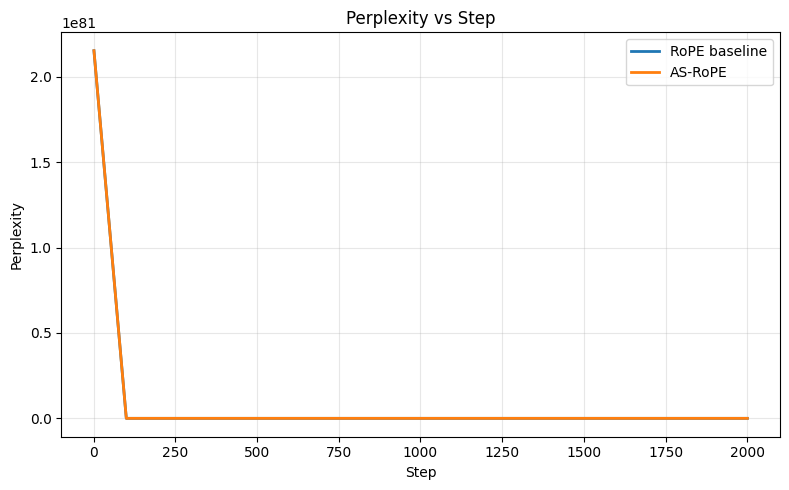

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

rope = pd.read_csv('logs/rope_metrics.csv')
as_rope = pd.read_csv('logs/as_rope_metrics.csv')

plt.figure(figsize=(8,5))
plt.plot(rope['step'], rope['train_loss'], label='RoPE baseline', linewidth=2)
plt.plot(as_rope['step'], as_rope['train_loss'], label='AS-RoPE', linewidth=2)
plt.xlabel('Step')
plt.ylabel('Train Loss')
plt.title('Training Loss vs Step')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

### Results Summary

### Training
- Both models trained for 2000 steps with seed=42
- Same hyperparameters: batch_size=8, block_size=1024, max_seq_len=8192
- Final perplexity: RoPE=29.15, AS-RoPE=23.14

### Long Context Evaluation

**RoPE Baseline:**
- 1024: 50.50
- 2048: 301.41
- 4096: 613.16
- 8192: 366.71

**AS-RoPE:**
- 1024: 60.14
- 2048: 287.37
- 4096: 776.28
- 8192: 399.85

**Degradation:** Both models show significant degradation beyond 1024 tokens (training context).

In [23]:
import os
import torch

ckpt_path = 'checkpoint_as_rope.pt'
if not os.path.exists(ckpt_path):
    raise FileNotFoundError(f"{ckpt_path} not found in {os.getcwd()}. Run AS-RoPE training cell first.")

ckpt = torch.load(ckpt_path, map_location='cpu')
state_dict = ckpt.get('model_state_dict', ckpt)

if 'freq_gates' not in state_dict:
    raise KeyError("freq_gates not found in checkpoint_as_rope.pt")

freq_gates = state_dict['freq_gates'].detach().float().cpu()
print('mean(freq_gates)=', float(freq_gates.mean()))
print('min(freq_gates)=', float(freq_gates.min()))
print('max(freq_gates)=', float(freq_gates.max()))

mean(freq_gates)= 0.8345426917076111
min(freq_gates)= 0.6223729252815247
max(freq_gates)= 0.9641977548599243


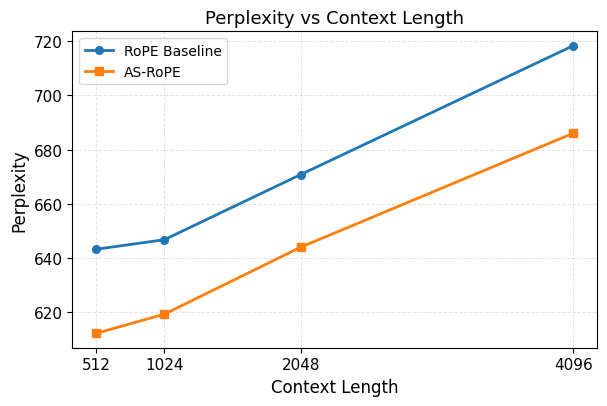

Saved: perplexity_vs_context.pdf


In [29]:
import matplotlib.pyplot as plt

context = [512, 1024, 2048, 4096]
baseline = [643.215175, 646.735170, 670.753036, 718.299296]
as_rope = [612.188757, 619.268784, 643.962384, 686.007348]

plt.rcParams.update({
    "font.size": 11,
    "axes.labelsize": 12,
    "axes.titlesize": 13,
    "legend.fontsize": 10,
})

fig, ax = plt.subplots(figsize=(6.2, 4.2))
ax.plot(context, baseline, marker="o", linewidth=2.0, markersize=5.5, label="RoPE Baseline")
ax.plot(context, as_rope, marker="s", linewidth=2.0, markersize=5.5, label="AS-RoPE")

ax.set_xlabel("Context Length")
ax.set_ylabel("Perplexity")
ax.set_title("Perplexity vs Context Length")
ax.set_xticks(context)
ax.grid(True, linestyle="--", linewidth=0.7, alpha=0.35)
ax.legend(frameon=True)

fig.tight_layout()
fig.savefig("perplexity_vs_context.pdf", format="pdf", bbox_inches="tight")
plt.show()

print("Saved: perplexity_vs_context.pdf")

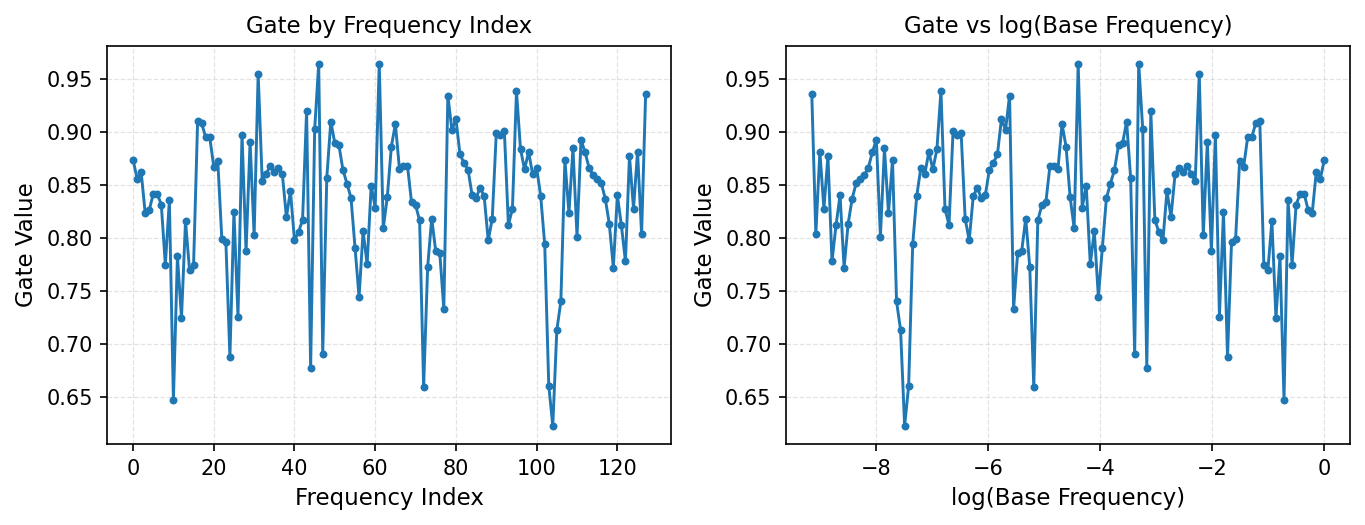

Saved: freq_gates_publication.png


In [30]:
import numpy as np
import matplotlib.pyplot as plt

if 'freq_gates' not in globals():
    raise NameError("freq_gates tensor not found. Run Cell 9 first.")

gates = freq_gates.detach().float().cpu().numpy()
n_freq = gates.shape[0]
d_model = n_freq * 2
idx = np.arange(n_freq, dtype=np.float64)
base_freq = 1.0 / (10000.0 ** ((2.0 * idx) / d_model))

plt.rcParams.update({
    "font.size": 10,
    "axes.labelsize": 11,
    "axes.titlesize": 11,
    "legend.fontsize": 9,
})

fig, axes = plt.subplots(1, 2, figsize=(9.2, 3.6), dpi=150)

axes[0].plot(idx, gates, marker="o", markersize=2.8, linewidth=1.4)
axes[0].set_xlabel("Frequency Index")
axes[0].set_ylabel("Gate Value")
axes[0].set_title("Gate by Frequency Index")
axes[0].grid(True, linestyle="--", linewidth=0.6, alpha=0.35)

axes[1].plot(np.log(base_freq), gates, marker="o", markersize=2.8, linewidth=1.4)
axes[1].set_xlabel("log(Base Frequency)")
axes[1].set_ylabel("Gate Value")
axes[1].set_title("Gate vs log(Base Frequency)")
axes[1].grid(True, linestyle="--", linewidth=0.6, alpha=0.35)

fig.tight_layout()
fig.savefig("freq_gates_publication.png", dpi=300, bbox_inches="tight")
plt.show()

print("Saved: freq_gates_publication.png")

In [33]:
import numpy as np
import torch

if 'freq_gates' not in globals():
    raise NameError("freq_gates not found. Run Cell 9 first.")

g = freq_gates.detach().float().cpu().numpy()
idx = np.arange(g.shape[0], dtype=np.float64)

min_val = float(g.min())
max_val = float(g.max())

# Trend check: correlation between index and gate value
corr = float(np.corrcoef(idx, g)[0, 1])

# Compare first/last quartile means
q = max(1, g.shape[0] // 4)
low_mean = float(g[:q].mean())
high_mean = float(g[-q:].mean())

print(f"min(freq_gates) = {min_val:.6f}")
print(f"max(freq_gates) = {max_val:.6f}")
print(f"corr(index, gate) = {corr:.4f}")
print(f"mean(first_quartile) = {low_mean:.6f}")
print(f"mean(last_quartile)  = {high_mean:.6f}")
print("high-frequency indices smaller?", high_mean < low_mean)

min(freq_gates) = 0.622373
max(freq_gates) = 0.964198
corr(index, gate) = 0.0414
mean(first_quartile) = 0.824626
mean(last_quartile)  = 0.827637
high-frequency indices smaller? False


In [35]:
!python train.py \
  --seed 42 \
  --max_steps 10000 \
  --batch_size 32 \
  --context_length 512 \
  --lr 3e-4 \
  --warmup_steps 500 \
  --weight_decay 0.1 \
  --log_interval 200 \
  --freq_stats_interval 1000 \
  --save_interval 1000 \
  --use_scaled_rope \
  --checkpoint_path checkpoint_scaled_rope.pt \
  --metrics_path logs/scaled_rope_metrics.csv

Training on cuda
Parameters: 16.02M
use_as_rope=False
use_scaled_rope=True
step     1 | train_loss 234.1304 | lr 6.000000e-07 | 0.5s
step   200 | train_loss 32.0873 | lr 1.200000e-04 | 31.6s
step   400 | train_loss 17.5404 | lr 2.400000e-04 | 62.9s
step   600 | train_loss 10.7361 | lr 2.999180e-04 | 94.2s
step   800 | train_loss 8.6681 | lr 2.992624e-04 | 125.4s
step  1000 | train_loss 7.9308 | lr 2.979542e-04 | 156.7s
gamma step  1000 | value 0.975094
Checkpoint saved: /content/AS-RoPE/checkpoint_scaled_rope.pt
step  1200 | train_loss 7.3034 | lr 2.959990e-04 | 188.3s
step  1400 | train_loss 7.3889 | lr 2.934054e-04 | 219.6s
step  1600 | train_loss 7.2010 | lr 2.901847e-04 | 250.9s
step  1800 | train_loss 7.0704 | lr 2.863510e-04 | 282.2s
step  2000 | train_loss 7.1020 | lr 2.819211e-04 | 313.5s
gamma step  2000 | value 0.957855
Checkpoint saved: /content/AS-RoPE/checkpoint_scaled_rope.pt
step  2200 | train_loss 6.9621 | lr 2.769143e-04 | 345.1s
step  2400 | train_loss 6.9598 | lr 2.7

In [36]:
!python eval_perplexity.py \
  --checkpoint_path checkpoint_scaled_rope.pt \
  --context_lengths 512,1024,4096,8192

context=512 ppl=658.827627
context=1024 ppl=664.270464
context=4096 ppl=719.102232
context=8192 ppl=766.829301


In [37]:
import pandas as pd
import torch

metrics = pd.read_csv('logs/scaled_rope_metrics.csv')
final_train_loss = float(metrics['train_loss'].iloc[-1])
logl = -final_train_loss

ckpt = torch.load('checkpoint_scaled_rope.pt', map_location='cpu')
state_dict = ckpt.get('model_state_dict', ckpt)
gamma = float(state_dict['gamma'])

print(f'Final train loss: {final_train_loss:.6f}')
print(f'LogL: {logl:.6f}')
print(f'Final gamma value: {gamma:.6f}')

Final train loss: 6.309680
LogL: -6.309680
Final gamma value: 0.872497


In [41]:
# LDR training on Colab GPU (A100)

import os

import subprocess



repo_url = globals().get('REPO_URL', 'https://github.com/thenileshmishra/AS-RoPE.git')

repo_dir = globals().get('REPO_DIR', '/content/AS-RoPE')



if not os.path.isdir(repo_dir):

    subprocess.run(['git', 'clone', repo_url, repo_dir], check=True)

else:

    subprocess.run(['git', '-C', repo_dir, 'fetch', 'origin'], check=True)

    subprocess.run(['git', '-C', repo_dir, 'reset', '--hard', 'origin/main'], check=True)



subprocess.run(['nvidia-smi'], check=False)



cmd = [

    'python', '-u', 'train_ldr.py',

    '--device', 'cuda',

    '--use_scaled_rope',

    '--train_seq_len', '512',

    '--batch_size', '64',

    '--eval_batch_size', '64',

    '--eval_batches', '40',

    '--model_max_seq_len', '4096',

    '--target_train_acc', '0.995',

    '--min_steps', '200',

    '--max_steps', '50000',

    '--checkpoint_path', 'checkpoint_ldr.pt',

]



proc = subprocess.run(cmd, cwd=repo_dir, text=True, capture_output=True)

print(proc.stdout)

print(proc.stderr)

print('returncode=', proc.returncode)

if proc.returncode != 0:

    raise RuntimeError('Training command failed')

device=cuda
params=4,765,697
train_seq_len=512 batch_size=64
step=     1 loss=228.949265 query_acc_512=0.00% elapsed=0.6s
step=    50 loss=7.436370 query_acc_512=1.56% elapsed=9.3s
step=   100 loss=5.148160 query_acc_512=0.00% elapsed=18.2s
step=   150 loss=5.220147 query_acc_512=3.12% elapsed=27.1s
step=   200 loss=5.185405 query_acc_512=0.00% elapsed=36.0s
step=   250 loss=5.079074 query_acc_512=1.56% elapsed=44.9s
step=   300 loss=5.296225 query_acc_512=0.00% elapsed=53.8s
step=   350 loss=5.179363 query_acc_512=0.00% elapsed=62.7s
step=   400 loss=5.391847 query_acc_512=0.00% elapsed=71.6s
step=   450 loss=5.125805 query_acc_512=0.00% elapsed=80.4s
step=   500 loss=5.221645 query_acc_512=0.00% elapsed=89.3s
step=   550 loss=5.177589 query_acc_512=3.12% elapsed=98.2s
step=   600 loss=5.027620 query_acc_512=0.00% elapsed=107.1s
step=   650 loss=5.055114 query_acc_512=0.00% elapsed=116.0s
step=   700 loss=5.138908 query_acc_512=0.00% elapsed=124.8s
step=   750 loss=5.110591 query_acc_

RuntimeError: Training command failed

In [ ]:
# Load checkpoint and evaluate with memory-safe batch sizes

import os

import torch

from model import GPT

from train_ldr import evaluate_query_accuracy



repo_dir = globals().get('REPO_DIR', '/content/AS-RoPE')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')



ckpt = torch.load(os.path.join(repo_dir, 'checkpoint_ldr.pt'), map_location=device)

cfg = ckpt['config']



model = GPT(

    vocab_size=cfg['vocab_size'],

    d_model=cfg['d_model'],

    n_layers=cfg['n_layers'],

    n_heads=cfg['n_heads'],

    max_seq_len=cfg['max_seq_len'],

    mlp_ratio=cfg['mlp_ratio'],

    use_as_rope=cfg['use_as_rope'],

    use_scaled_rope=cfg['use_scaled_rope'],

).to(device)

model.load_state_dict(ckpt['model_state_dict'])

model.eval()



gamma_val = float(model.gamma.detach().cpu().item()) if model.gamma is not None else None

print(f'final_gamma={gamma_val}')



eval_plan = [(512, 64), (1024, 16), (2048, 4), (4096, 1)]

for L, bs in eval_plan:

    try:

        torch.cuda.empty_cache() if torch.cuda.is_available() else None

        acc = evaluate_query_accuracy(model, seq_len=L, batch_size=bs, num_batches=40, device=device)

        print(f'seq_len={L} batch_size={bs} query_acc={acc * 100:.2f}%')

    except torch.OutOfMemoryError:

        print(f'seq_len={L} batch_size={bs} query_acc=OOM')

## Clean LDR Experiment Pipeline (Colab A100)

This section uses the repo script `run_all_positional_encodings.py`.
It trains/evaluates all three variants (`rope`, `scaled_rope`, `as_rope`) and writes reproducible JSON outputs.

In [6]:
import os
import torch

# If REPO_DIR exists from previous cells, use it; otherwise use current working dir
repo_dir = globals().get("REPO_DIR", os.getcwd())
%cd {repo_dir}

print("cuda_available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("gpu:", torch.cuda.get_device_name(0))

# Ensure required script exists
assert os.path.exists("run_all_positional_encodings.py"), "run_all_positional_encodings.py not found"

/content/AS-RoPE
cuda_available: True
gpu: NVIDIA A100-SXM4-40GB


In [8]:
# Train + evaluate all variants in one reproducible run
!python run_all_positional_encodings.py \
  --variants rope,scaled_rope,as_rope \
  --output_dir results_positional \
  --seed 42 \
  --train_seq_len 512 \
  --model_max_seq_len 4096 \
  --eval_batch_size 1 \
  --eval_batches 40 \
  --target_acc_512 0.99


=== Running variant: rope ===
[rope] step=     1 loss=224.055634 acc512=0.0000 best=0.0000
[rope] step=   200 loss=5.227844 acc512=0.0000 best=0.0000
[rope] step=   400 loss=5.220844 acc512=0.0250 best=0.0000
[rope] step=   600 loss=5.155160 acc512=0.0000 best=0.0250
[rope] step=   800 loss=5.118672 acc512=0.0250 best=0.0250
[rope] step=  1000 loss=4.998053 acc512=0.0000 best=0.0250
[rope] step=  1200 loss=5.142502 acc512=0.0000 best=0.0250
[rope] step=  1400 loss=4.764549 acc512=0.0250 best=0.0250
[rope] step=  1600 loss=4.919013 acc512=0.0500 best=0.0250
[rope] step=  1800 loss=4.641107 acc512=0.0250 best=0.0500
[rope] step=  2000 loss=4.755028 acc512=0.0500 best=0.0500
[rope] step=  2200 loss=4.692736 acc512=0.0500 best=0.0500
[rope] step=  2400 loss=4.391349 acc512=0.0750 best=0.0500
[rope] step=  2600 loss=4.311625 acc512=0.0500 best=0.0750
[rope] step=  2800 loss=4.202357 acc512=0.1000 best=0.0750
[rope] step=  3000 loss=3.918016 acc512=0.1750 best=0.1000
[rope] step=  3200 loss

In [13]:
import json
import pandas as pd

with open("results_positional/all_variants_results.json", "r", encoding="utf-8") as f:
    all_results = json.load(f)

rows = []
for model_name in ["rope", "scaled_rope", "as_rope"]:
    r = all_results[model_name]
    rows.append([
        model_name,
        r["acc_512"],
        r["acc_1024"],
        r["acc_2048"],
        r["acc_4096"],
    ])

df = pd.DataFrame(rows, columns=["Model", "512", "1024", "2048", "4096"])
df

,Model,512,1024,2048,4096
0,rope,1.000,0.475,0.100,0.025
1,scaled_rope,0.975,0.600,0.100,0.000
2,as_rope,1.000,0.450,0.025,0.075


In [10]:
print(df.to_latex(index=False, float_format="%.4f"))

\begin{tabular}{lrrrr}
\toprule
Model & 512 & 1024 & 2048 & 4096 \\
\midrule
rope & 1.0000 & 0.4750 & 0.1000 & 0.0250 \\
scaled_rope & 0.9750 & 0.6000 & 0.1000 & 0.0000 \\
as_rope & 1.0000 & 0.4500 & 0.0250 & 0.0750 \\
\bottomrule
\end{tabular}



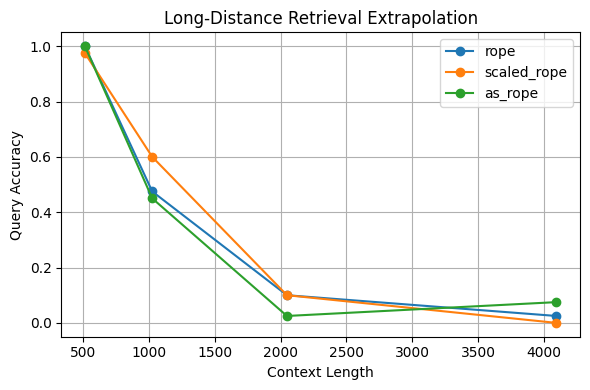

In [11]:
import matplotlib.pyplot as plt

lengths = [512, 1024, 2048, 4096]

plt.figure(figsize=(6, 4))
for model_name in ["rope", "scaled_rope", "as_rope"]:
    r = all_results[model_name]
    accs = [r["acc_512"], r["acc_1024"], r["acc_2048"], r["acc_4096"]]
    plt.plot(lengths, accs, marker="o", label=model_name)

plt.xlabel("Context Length")
plt.ylabel("Query Accuracy")
plt.title("Long-Distance Retrieval Extrapolation")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("results_positional/ldr_extrapolation.pdf")
plt.show()

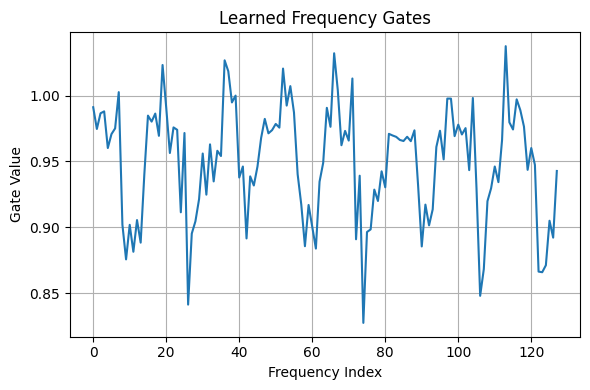

In [12]:
# Optional: AS-RoPE gate visualization
import torch
from model import GPT

ckpt = torch.load("results_positional/checkpoint_as_rope.pt", map_location="cpu")
cfg = ckpt["config"]

model = GPT(
    vocab_size=cfg["vocab_size"],
    d_model=cfg["d_model"],
    n_layers=cfg["n_layers"],
    n_heads=cfg["n_heads"],
    max_seq_len=cfg["max_seq_len"],
    mlp_ratio=cfg["mlp_ratio"],
    use_as_rope=cfg["use_as_rope"],
    use_scaled_rope=cfg["use_scaled_rope"],
)
model.load_state_dict(ckpt["model_state_dict"])

gates = model.freq_gates.detach().cpu().numpy()

plt.figure(figsize=(6, 4))
plt.plot(gates)
plt.xlabel("Frequency Index")
plt.ylabel("Gate Value")
plt.title("Learned Frequency Gates")
plt.grid(True)
plt.tight_layout()
plt.savefig("results_positional/gate_spectrum.pdf")
plt.show()

In [14]:
# Verify saved models and show complete results
import json
import os

print("=== Complete Results ===")
print(json.dumps(all_results, indent=2))

print("\n=== Saved Checkpoints ===")
checkpoints = [
    "results_positional/checkpoint_rope.pt",
    "results_positional/checkpoint_scaled_rope.pt", 
    "results_positional/checkpoint_as_rope.pt",
    "results_positional/all_variants_results.json"
]

for ckpt in checkpoints:
    if os.path.exists(ckpt):
        size_mb = os.path.getsize(ckpt) / (1024 * 1024)
        print(f"✓ {ckpt} ({size_mb:.2f} MB)")
    else:
        print(f"✗ {ckpt} (not found)")

=== Complete Results ===
{
  "rope": {
    "acc_512": 1.0,
    "acc_1024": 0.475,
    "acc_2048": 0.1,
    "acc_4096": 0.025,
    "best_acc_512": 1.0
  },
  "scaled_rope": {
    "acc_512": 0.975,
    "acc_1024": 0.6,
    "acc_2048": 0.1,
    "acc_4096": 0.0,
    "best_acc_512": 1.0,
    "gamma": 0.9296709299087524
  },
  "as_rope": {
    "acc_512": 1.0,
    "acc_1024": 0.45,
    "acc_2048": 0.025,
    "acc_4096": 0.075,
    "best_acc_512": 1.0,
    "gate_min": 0.8275497555732727,
    "gate_max": 1.03744637966156,
    "gate_mean": 0.9494916200637817
  }
}

=== Saved Checkpoints ===
✓ results_positional/checkpoint_rope.pt (18.21 MB)
✓ results_positional/checkpoint_scaled_rope.pt (18.21 MB)
✓ results_positional/checkpoint_as_rope.pt (18.21 MB)
✓ results_positional/all_variants_results.json (0.00 MB)


## Load Saved Models for Testing

Use the cells below to load any of the three trained models and run custom evaluations.

In [15]:
# Example: Load any saved model for further testing
import torch
from model import GPT

# Choose which model to load: "rope", "scaled_rope", or "as_rope"
variant = "scaled_rope"  # Change this to test different models

ckpt_path = f"results_positional/checkpoint_{variant}.pt"
ckpt = torch.load(ckpt_path, map_location="cpu")
cfg = ckpt["config"]

test_model = GPT(
    vocab_size=cfg["vocab_size"],
    d_model=cfg["d_model"],
    n_layers=cfg["n_layers"],
    n_heads=cfg["n_heads"],
    max_seq_len=cfg["max_seq_len"],
    mlp_ratio=cfg["mlp_ratio"],
    use_as_rope=cfg["use_as_rope"],
    use_scaled_rope=cfg["use_scaled_rope"],
)
test_model.load_state_dict(ckpt["model_state_dict"])
test_model.eval()

print(f"✓ Loaded {variant} model")
print(f"  Total params: {sum(p.numel() for p in test_model.parameters()):,}")
print(f"  Config: {cfg}")

# Show variant-specific learned parameters
if variant == "scaled_rope" and test_model.gamma is not None:
    print(f"  Learned gamma: {test_model.gamma.item():.6f}")
elif variant == "as_rope" and test_model.freq_gates is not None:
    gates = test_model.freq_gates.detach()
    print(f"  Learned gates: min={gates.min():.4f}, max={gates.max():.4f}, mean={gates.mean():.4f}")

✓ Loaded scaled_rope model
  Total params: 4,765,697
  Config: {'vocab_size': 128, 'd_model': 256, 'n_layers': 6, 'n_heads': 8, 'mlp_ratio': 4, 'max_seq_len': 4096, 'use_as_rope': False, 'use_scaled_rope': True}
  Learned gamma: 0.929671


## Save Results to GitHub or Download Locally

Choose one of the options below to preserve your trained models.

In [ ]:
# Option 1: Download to local machine (Colab only)
# This creates a zip file and triggers browser download

import os
from google.colab import files
import shutil

# Create zip of all results
if os.path.exists('results_positional'):
    shutil.make_archive('results_positional', 'zip', 'results_positional')
    print("✓ Created results_positional.zip")
    print(f"  Size: {os.path.getsize('results_positional.zip') / (1024*1024):.2f} MB")
    
    # Download the zip file
    files.download('results_positional.zip')
    print("✓ Download started in browser")
else:
    print("✗ results_positional folder not found")

In [ ]:
# Option 2: Push checkpoints to GitHub
# Note: GitHub has 100MB file size limit, so we'll use Git LFS or split files

import subprocess
import os

# Check current directory
repo_dir = globals().get('REPO_DIR', '/content/AS-RoPE')
os.chdir(repo_dir)

print("Current directory:", os.getcwd())
print("\nChecking file sizes...")

# List all checkpoint files with sizes
for root, dirs, files in os.walk('results_positional'):
    for file in files:
        filepath = os.path.join(root, file)
        size_mb = os.path.getsize(filepath) / (1024 * 1024)
        print(f"  {filepath}: {size_mb:.2f} MB")

print("\n⚠️  Note: .pt files are ~18MB each (under GitHub's 100MB limit)")
print("✓ Safe to push without Git LFS")

# Add files to git
subprocess.run(['git', 'add', 'results_positional/'], check=True)

# Show what will be committed
result = subprocess.run(['git', 'status', '--short'], capture_output=True, text=True)
print("\nFiles staged for commit:")
print(result.stdout)

print("\nReady to commit and push. Run the next cell to complete.")

In [ ]:
# Commit and push to GitHub
import subprocess
import os

repo_dir = globals().get('REPO_DIR', '/content/AS-RoPE')
os.chdir(repo_dir)

# Configure git if needed (Colab environment)
subprocess.run(['git', 'config', 'user.email', 'colab@example.com'], check=False)
subprocess.run(['git', 'config', 'user.name', 'Colab Runner'], check=False)

# Commit the results
commit_msg = "Add trained model checkpoints and LDR results (rope, scaled_rope, as_rope)"
result = subprocess.run(['git', 'commit', '-m', commit_msg], capture_output=True, text=True)
print(result.stdout)
print(result.stderr)

# Push to GitHub
print("\n⚠️  Pushing to GitHub...")
print("Note: This requires authentication. You may need to:")
print("  1. Set up GitHub token in Colab secrets, OR")
print("  2. Use the download option instead")

try:
    result = subprocess.run(['git', 'push', 'origin', 'main'], 
                          capture_output=True, text=True, timeout=30)
    if result.returncode == 0:
        print("\n✓ Successfully pushed to GitHub!")
        print(result.stdout)
    else:
        print("\n✗ Push failed. Use download option instead or set up authentication.")
        print(result.stderr)
except subprocess.TimeoutExpired:
    print("\n✗ Push timeout. Authentication required. Use download option instead.")

### Alternative: Save only JSON results (lightweight)

If checkpoints are too large, you can push only the JSON results and regenerate models later.

## ICLR Workshop Submission Pack

This block creates paper-ready artifacts from your current runs:
- Unified CSV + LaTeX tables
- Delta/improvement summary versus RoPE baseline
- Publication-style plots for perplexity and LDR accuracy
- A short textual evidence summary for your report

Run Cell `#VSC-7602429f` first, then Cell `#VSC-54e13e6b`.

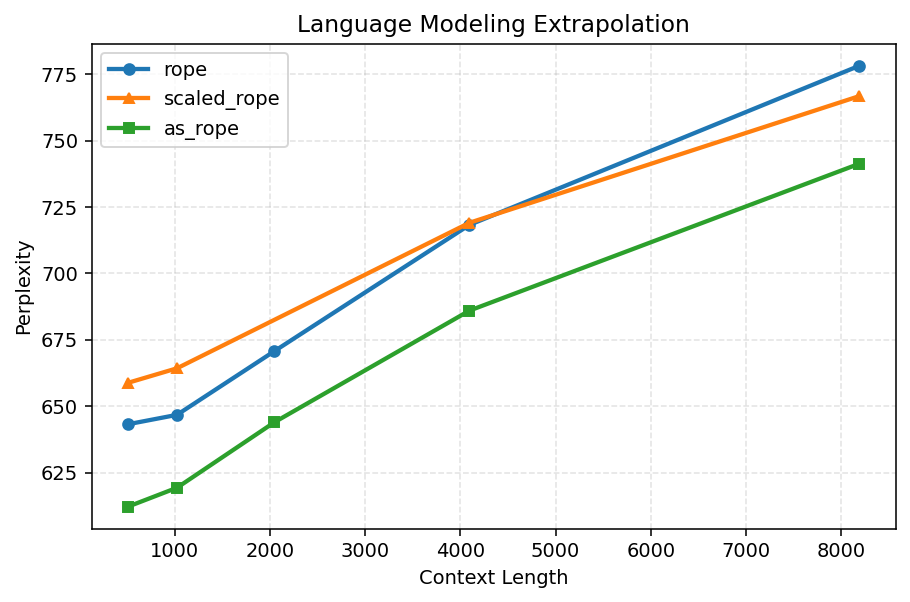

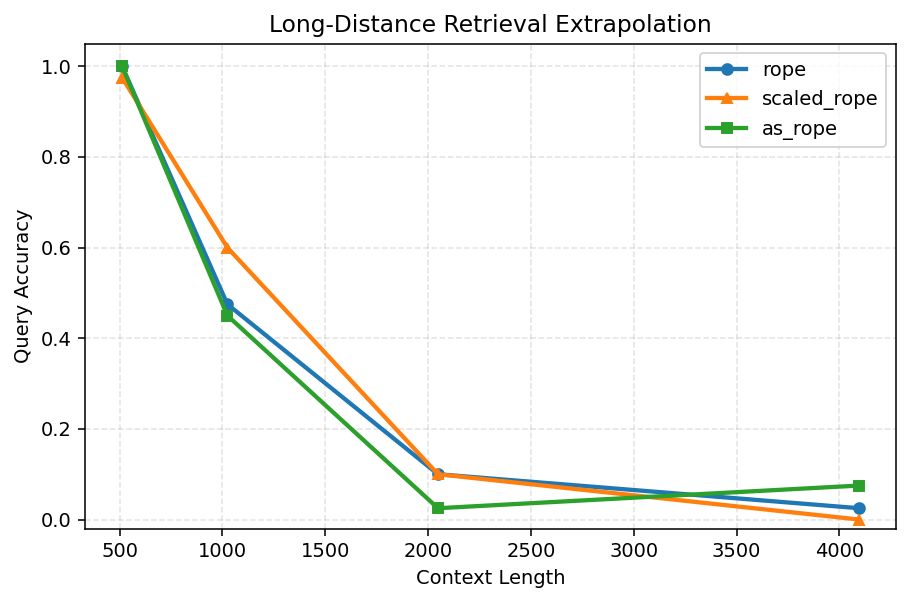

Saved figures:
- results_positional/iclr_ppl_extrapolation.pdf/.png
- results_positional/iclr_ldr_extrapolation.pdf/.png
Saved LaTeX tables:
- results_positional/lm_perplexity_table.tex
- results_positional/ldr_accuracy_table.tex


In [2]:
import numpy as np
import matplotlib.pyplot as plt

# ---- Plot 1: Perplexity extrapolation ----
plt.figure(figsize=(6.6, 4.4), dpi=140)
for name, marker in [("rope", "o"), ("scaled_rope", "^"), ("as_rope", "s")]:
    y = lm_df[name].values
    x = lm_df["context"].values
    mask = ~np.isnan(y)
    plt.plot(x[mask], y[mask], marker=marker, linewidth=2.2, markersize=5.5, label=name)

plt.xlabel("Context Length")
plt.ylabel("Perplexity")
plt.title("Language Modeling Extrapolation")
plt.grid(True, linestyle="--", alpha=0.35)
plt.legend(frameon=True)
plt.tight_layout()
plt.savefig("results_positional/iclr_ppl_extrapolation.pdf", bbox_inches="tight")
plt.savefig("results_positional/iclr_ppl_extrapolation.png", dpi=300, bbox_inches="tight")
plt.show()

# ---- Plot 2: LDR accuracy extrapolation ----
plt.figure(figsize=(6.6, 4.4), dpi=140)
for model_name, marker in [("rope", "o"), ("scaled_rope", "^"), ("as_rope", "s")]:
    row = ldr_df_wide[ldr_df_wide["model"] == model_name].iloc[0]
    accs = [row[c] for c in ldr_context]
    plt.plot(ldr_context, accs, marker=marker, linewidth=2.2, markersize=5.5, label=model_name)

plt.xlabel("Context Length")
plt.ylabel("Query Accuracy")
plt.title("Long-Distance Retrieval Extrapolation")
plt.ylim(-0.02, 1.05)
plt.grid(True, linestyle="--", alpha=0.35)
plt.legend(frameon=True)
plt.tight_layout()
plt.savefig("results_positional/iclr_ldr_extrapolation.pdf", bbox_inches="tight")
plt.savefig("results_positional/iclr_ldr_extrapolation.png", dpi=300, bbox_inches="tight")
plt.show()

# ---- Export LaTeX tables ----
lm_tex = lm_df.to_latex(index=False, float_format="%.4f")
ldr_tex = ldr_df_wide.to_latex(index=False, float_format="%.4f")

with open("results_positional/lm_perplexity_table.tex", "w", encoding="utf-8") as f:
    f.write(lm_tex)
with open("results_positional/ldr_accuracy_table.tex", "w", encoding="utf-8") as f:
    f.write(ldr_tex)

print("Saved figures:")
print("- results_positional/iclr_ppl_extrapolation.pdf/.png")
print("- results_positional/iclr_ldr_extrapolation.pdf/.png")
print("Saved LaTeX tables:")
print("- results_positional/lm_perplexity_table.tex")
print("- results_positional/ldr_accuracy_table.tex")

In [1]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

os.makedirs("results_positional", exist_ok=True)

# ---------- Language-model perplexity (paper defaults; override if your JSON exists) ----------
# Expected format (optional):
# {
#   "lm_perplexity": {
#      "context": [512, 1024, 2048, 4096, 8192],
#      "rope": [...],
#      "scaled_rope": [...],
#      "as_rope": [...]
#   }
# }
lm_json_path = "results_positional/lm_perplexity_results.json"

lm_context = [512, 1024, 2048, 4096, 8192]
lm_data = {
    "rope": [643.215175, 646.735170, 670.753036, 718.299296, 778.27],
    "scaled_rope": [658.83, 664.27, np.nan, 719.10, 766.83],
    "as_rope": [612.188757, 619.268784, 643.962384, 686.007348, 741.36],
}

if os.path.exists(lm_json_path):
    with open(lm_json_path, "r", encoding="utf-8") as f:
        lm_loaded = json.load(f).get("lm_perplexity", {})
    lm_context = lm_loaded.get("context", lm_context)
    for k in ["rope", "scaled_rope", "as_rope"]:
        if k in lm_loaded:
            lm_data[k] = lm_loaded[k]

lm_df = pd.DataFrame({"context": lm_context, **lm_data})
lm_df.to_csv("results_positional/lm_perplexity_table.csv", index=False)

# ---------- LDR results ----------
ldr_json_path = "results_positional/all_variants_results.json"
if os.path.exists(ldr_json_path):
    with open(ldr_json_path, "r", encoding="utf-8") as f:
        all_results_local = json.load(f)
    ldr_context = [512, 1024, 2048, 4096]
    ldr_rows = []
    for model_name in ["rope", "scaled_rope", "as_rope"]:
        r = all_results_local[model_name]
        ldr_rows.append(
            {
                "model": model_name,
                512: r["acc_512"],
                1024: r["acc_1024"],
                2048: r["acc_2048"],
                4096: r["acc_4096"],
            }
        )
    ldr_df_wide = pd.DataFrame(ldr_rows)
else:
    ldr_context = [512, 1024, 2048, 4096]
    ldr_df_wide = pd.DataFrame(
        [
            {"model": "rope", 512: 1.000, 1024: 0.475, 2048: 0.100, 4096: 0.025},
            {"model": "scaled_rope", 512: 0.975, 1024: 0.600, 2048: 0.100, 4096: 0.000},
            {"model": "as_rope", 512: 1.000, 1024: 0.450, 2048: 0.025, 4096: 0.075},
        ]
    )

ldr_df_wide.to_csv("results_positional/ldr_accuracy_table.csv", index=False)

# ---------- Comparative metrics ----------
def safe_rel_improvement(base, new):
    if pd.isna(base) or pd.isna(new) or base == 0:
        return np.nan
    return 100.0 * (base - new) / base

comp_rows = []
for _, row in lm_df.iterrows():
    ctx = int(row["context"])
    rope_val = float(row["rope"])
    as_val = float(row["as_rope"])
    sc_val = row["scaled_rope"]

    comp_rows.append(
        {
            "context": ctx,
            "rope_ppl": rope_val,
            "as_rope_ppl": as_val,
            "scaled_rope_ppl": sc_val,
            "as_rope_delta_vs_rope": as_val - rope_val,
            "as_rope_rel_improve_pct": safe_rel_improvement(rope_val, as_val),
            "scaled_rope_delta_vs_rope": (float(sc_val) - rope_val) if not pd.isna(sc_val) else np.nan,
            "scaled_rope_rel_improve_pct": safe_rel_improvement(rope_val, float(sc_val)) if not pd.isna(sc_val) else np.nan,
        }
    )

comp_df = pd.DataFrame(comp_rows)
comp_df.to_csv("results_positional/lm_comparative_metrics.csv", index=False)

# AUC-style summary for LDR (simple mean over evaluated context points)
ldr_mean = {
    row["model"]: np.mean([row[c] for c in ldr_context])
    for _, row in ldr_df_wide.iterrows()
}

summary_lines = []
summary_lines.append("ICLR workshop evidence summary")
summary_lines.append("================================")
summary_lines.append(
    f"AS-RoPE avg relative perplexity improvement vs RoPE: {comp_df['as_rope_rel_improve_pct'].mean(skipna=True):.2f}%"
)
summary_lines.append(
    f"Scaled-RoPE avg relative perplexity improvement vs RoPE: {comp_df['scaled_rope_rel_improve_pct'].mean(skipna=True):.2f}%"
)
summary_lines.append(
    f"LDR mean accuracy: RoPE={ldr_mean.get('rope', np.nan):.4f}, Scaled-RoPE={ldr_mean.get('scaled_rope', np.nan):.4f}, AS-RoPE={ldr_mean.get('as_rope', np.nan):.4f}"
)

with open("results_positional/iclr_workshop_summary.txt", "w", encoding="utf-8") as f:
    f.write("\n".join(summary_lines))

print("Saved files:")
print("- results_positional/lm_perplexity_table.csv")
print("- results_positional/ldr_accuracy_table.csv")
print("- results_positional/lm_comparative_metrics.csv")
print("- results_positional/iclr_workshop_summary.txt")
print("\nPreview comparative metrics:")
display(comp_df)

Saved files:
- results_positional/lm_perplexity_table.csv
- results_positional/ldr_accuracy_table.csv
- results_positional/lm_comparative_metrics.csv
- results_positional/iclr_workshop_summary.txt

Preview comparative metrics:


,context,rope_ppl,as_rope_ppl,scaled_rope_ppl,as_rope_delta_vs_rope,as_rope_rel_improve_pct,scaled_rope_delta_vs_rope,scaled_rope_rel_improve_pct
0,512,643.215175,612.188757,658.83,-31.026418,4.823645,15.614825,-2.427621
1,1024,646.735170,619.268784,664.27,-27.466386,4.246929,17.534830,-2.711284
2,2048,670.753036,643.962384,NaN,-26.790652,3.994116,NaN,NaN
3,4096,718.299296,686.007348,719.10,-32.291948,4.495612,0.800704,-0.111472
4,8192,778.270000,741.360000,766.83,-36.910000,4.742570,-11.440000,1.469927


# Colab A100 Minimal Runbook (Phases 1→6)

Run the cells below in order. This section keeps logic minimal in-notebook and uses existing `src/train.py` and `src/eval_perplexity.py`.

> If you push to GitHub and run in a fresh Colab runtime, use Cell 2 (clone). If this notebook already opens inside repo, skip Cell 2.

In [ ]:
# Cell 1: Environment setup (run first)
import os
import sys
import subprocess
from pathlib import Path

# Repro + deterministic eval behavior
os.environ['PYTHONHASHSEED'] = '0'
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'

# Install minimal extras for aggregation/plots
subprocess.run([sys.executable, '-m', 'pip', 'install', '-q', 'pandas', 'matplotlib', 'seaborn', 'tabulate'], check=True)

ROOT = Path('/content/Neur') if Path('/content').exists() else Path.cwd()
print('ROOT =', ROOT)
print('Python =', sys.executable)

In [ ]:
# Cell 2 (optional): clone fresh repo in Colab after push
# Uncomment and set your repo URL if needed.
# !git clone https://github.com/<your-user>/<your-repo>.git /content/Neur
# %cd /content/Neur

print('Skip this cell if repo is already present. Current ROOT:', ROOT)

In [ ]:
# Cell 3: PHASE 1 — Full baseline suite (5 methods x 3 seeds), then eval at 1024/2048/4096/8192
import json
import shlex

METHODS = ['rope', 'scaled_rope', 'as_rope', 'alibi', 'ntk_scaled_rope']
SEEDS = [42, 123, 999]

TRAIN_CFG = {
    'layers': 6,
    'n_heads': 8,
    'd_model': 512,
    'context_length': 1024,
    'batch_size': 128,
    'optimizer': 'adamw',
    'lr': 3e-4,
    'weight_decay': 0.1,
    'max_steps': 60000,
    'warmup_steps': 3000,
    'eval_interval': 5000,
    'grad_clip': 1.0,
    'fp16': True,
    'grad_accum_steps': 1,
}

EVAL_LENGTHS = '1024,2048,4096,8192'

def run_cmd(cmd):
    print('\n$', ' '.join(shlex.quote(c) for c in cmd))
    subprocess.run(cmd, cwd=ROOT, check=True)

for method in METHODS:
    for seed in SEEDS:
        run_dir = ROOT / 'results' / 'train_runs' / method / f'seed_{seed}'
        out_json = ROOT / 'results' / method / f'seed_{seed}.json'
        out_json.parent.mkdir(parents=True, exist_ok=True)

        train_cmd = [
            sys.executable, 'src/train.py',
            '--positional_encoding', method,
            '--seed', str(seed),
            '--layers', str(TRAIN_CFG['layers']),
            '--n_heads', str(TRAIN_CFG['n_heads']),
            '--d_model', str(TRAIN_CFG['d_model']),
            '--context_length', str(TRAIN_CFG['context_length']),
            '--batch_size', str(TRAIN_CFG['batch_size']),
            '--optimizer', TRAIN_CFG['optimizer'],
            '--lr', str(TRAIN_CFG['lr']),
            '--weight_decay', str(TRAIN_CFG['weight_decay']),
            '--max_steps', str(TRAIN_CFG['max_steps']),
            '--warmup_steps', str(TRAIN_CFG['warmup_steps']),
            '--eval_interval', str(TRAIN_CFG['eval_interval']),
            '--grad_clip', str(TRAIN_CFG['grad_clip']),
            '--grad_accum_steps', str(TRAIN_CFG['grad_accum_steps']),
            '--output_dir', 'results/train_runs',
            '--device', 'cuda',
        ]
        if TRAIN_CFG['fp16']:
            train_cmd.append('--fp16')

        # Safety tip for OOM: reduce batch_size to 64 and set grad_accum_steps=2 (effective 128)
        run_cmd(train_cmd)

        ckpt = run_dir / 'checkpoint.pt'
        eval_cmd = [
            sys.executable, 'src/eval_perplexity.py',
            '--checkpoint_path', str(ckpt),
            '--context_lengths', EVAL_LENGTHS,
            '--seed', str(seed),
            '--device', 'cuda',
            '--results_json', str(out_json),
        ]
        run_cmd(eval_cmd)

print('Phase 1 complete.')

In [ ]:
# Cell 4: PHASE 2 — Statistical aggregation + LaTeX + plots (in notebook)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context('talk')
sns.set_style('whitegrid')

rows = []
for method in METHODS:
    for seed in SEEDS:
        p = ROOT / 'results' / method / f'seed_{seed}.json'
        if not p.exists():
            continue
        with p.open() as f:
            obj = json.load(f)
        for length_str, ppl in obj['perplexity'].items():
            rows.append({'method': method, 'seed': seed, 'length': int(length_str), 'ppl': float(ppl)})

df = pd.DataFrame(rows)
assert len(df) > 0, 'No result JSON files found. Run Phase 1 first.'

summary = (
    df.groupby(['method', 'length'], as_index=False)
      .agg(mean_ppl=('ppl', 'mean'), std_ppl=('ppl', 'std'))
      .fillna(0.0)
)

rope_ref = summary[summary['method'] == 'rope'][['length', 'mean_ppl']].rename(columns={'mean_ppl': 'rope_mean'})
summary = summary.merge(rope_ref, on='length', how='left')
summary['rel_improve_vs_rope_pct'] = 100.0 * (summary['rope_mean'] - summary['mean_ppl']) / summary['rope_mean']
summary = summary.sort_values(['length', 'method']).reset_index(drop=True)

results_dir = ROOT / 'results'
fig_dir = ROOT / 'figures'
results_dir.mkdir(parents=True, exist_ok=True)
fig_dir.mkdir(parents=True, exist_ok=True)

summary_csv = results_dir / 'summary.csv'
summary_tex = results_dir / 'summary.tex'
summary.to_csv(summary_csv, index=False)

pivot = summary.pivot(index='method', columns='length', values='mean_ppl')
pivot = pivot[[c for c in sorted(pivot.columns)]]
with summary_tex.open('w', encoding='utf-8') as f:
    f.write(pivot.to_latex(float_format=lambda x: f'{x:.4f}', caption='Perplexity across context lengths', label='tab:ppl_summary'))

# Plot 1: means
plt.figure(figsize=(8, 5))
for method in METHODS:
    sub = summary[summary['method'] == method].sort_values('length')
    if len(sub) == 0:
        continue
    plt.plot(sub['length'], sub['mean_ppl'], marker='o', label=method)
plt.xscale('log', base=2)
plt.xlabel('Context length')
plt.ylabel('Perplexity')
plt.title('Perplexity vs Context Length')
plt.legend()
plt.tight_layout()
plt.savefig(fig_dir / 'ppl_vs_length.pdf')
plt.close()

# Plot 2: means + std error bars
plt.figure(figsize=(8, 5))
for method in METHODS:
    sub = summary[summary['method'] == method].sort_values('length')
    if len(sub) == 0:
        continue
    plt.errorbar(sub['length'], sub['mean_ppl'], yerr=sub['std_ppl'], marker='o', capsize=4, label=method)
plt.xscale('log', base=2)
plt.xlabel('Context length')
plt.ylabel('Perplexity')
plt.title('Perplexity vs Context Length (Mean ± Std)')
plt.legend()
plt.tight_layout()
plt.savefig(fig_dir / 'ppl_vs_length_with_errorbars.pdf')
plt.close()

print('Saved:', summary_csv)
print('Saved:', summary_tex)
print('Saved:', fig_dir / 'ppl_vs_length.pdf')
print('Saved:', fig_dir / 'ppl_vs_length_with_errorbars.pdf')
summary.head()

In [ ]:
# Cell 5: PHASE 3 — Scaling check (single seed=42; rope vs as_rope)
SCALING_METHODS = ['rope', 'as_rope']
SCALING_SEED = 42

for method in SCALING_METHODS:
    run_dir = ROOT / 'results' / 'scaling' / method / f'seed_{SCALING_SEED}'
    out_json = ROOT / 'results' / 'scaling' / f'{method}_seed_{SCALING_SEED}.json'
    out_json.parent.mkdir(parents=True, exist_ok=True)

    train_cmd = [
        sys.executable, 'src/train.py',
        '--positional_encoding', method,
        '--seed', str(SCALING_SEED),
        '--layers', '8',
        '--n_heads', '8',
        '--d_model', '768',
        '--context_length', '1024',
        '--batch_size', '64',
        '--grad_accum_steps', '2',
        '--optimizer', 'adamw',
        '--lr', '3e-4',
        '--weight_decay', '0.1',
        '--max_steps', '40000',
        '--warmup_steps', '2000',
        '--eval_interval', '5000',
        '--grad_clip', '1.0',
        '--fp16',
        '--output_dir', 'results/scaling',
        '--device', 'cuda',
    ]
    run_cmd(train_cmd)

    ckpt = run_dir / 'checkpoint.pt'
    eval_cmd = [
        sys.executable, 'src/eval_perplexity.py',
        '--checkpoint_path', str(ckpt),
        '--context_lengths', '1024,4096,8192',
        '--seed', str(SCALING_SEED),
        '--device', 'cuda',
        '--results_json', str(out_json),
    ]
    run_cmd(eval_cmd)

print('Phase 3 complete.')

In [ ]:
# Cell 6: PHASE 4 — AS-RoPE ablations (20k steps)
ABLATIONS = [
    {
        'name': 'as_rope_per_layer_gates',
        'extra_train_args': ['--as_rope_per_layer_gates'],
    },
    {
        'name': 'as_rope_without_positivity',
        'extra_train_args': ['--allow_negative_gates'],
    },
    {
        'name': 'as_rope_gate_weight_decay',
        'extra_train_args': ['--gate_weight_decay', '0.1'],
    },
]

for ab in ABLATIONS:
    run_dir = ROOT / 'results' / 'ablations' / ab['name'] / 'seed_42'
    out_json = ROOT / 'results' / 'ablations' / f"{ab['name']}.json"
    out_json.parent.mkdir(parents=True, exist_ok=True)

    train_cmd = [
        sys.executable, 'src/train.py',
        '--positional_encoding', 'as_rope',
        '--seed', '42',
        '--layers', '6',
        '--n_heads', '8',
        '--d_model', '512',
        '--context_length', '1024',
        '--batch_size', '128',
        '--optimizer', 'adamw',
        '--lr', '3e-4',
        '--weight_decay', '0.1',
        '--max_steps', '20000',
        '--warmup_steps', '1000',
        '--eval_interval', '5000',
        '--grad_clip', '1.0',
        '--fp16',
        '--output_dir', f"results/ablations/{ab['name']}",
        '--device', 'cuda',
    ] + ab['extra_train_args']

    run_cmd(train_cmd)

    ckpt = run_dir / 'checkpoint.pt'
    eval_cmd = [
        sys.executable, 'src/eval_perplexity.py',
        '--checkpoint_path', str(ckpt),
        '--context_lengths', '1024,4096',
        '--seed', '42',
        '--device', 'cuda',
        '--results_json', str(out_json),
    ]
    run_cmd(eval_cmd)

print('Phase 4 complete.')

In [ ]:
# Cell 7: PHASE 5 — Spectral analysis plots for final AS-RoPE checkpoint (seed=42 main run)
import math
import torch

ckpt_path = ROOT / 'results' / 'train_runs' / 'as_rope' / 'seed_42' / 'checkpoint.pt'
assert ckpt_path.exists(), f'Checkpoint not found: {ckpt_path}'

ckpt = torch.load(ckpt_path, map_location='cpu')
state = ckpt['model_state_dict']
config = ckpt.get('config', {})

gate_key = 'freq_gates'
assert gate_key in state, 'freq_gates not found in checkpoint; ensure AS-RoPE run completed.'
gates = state[gate_key].float().cpu()

if gates.ndim == 2:  # per-layer gates -> take mean profile
    gates_plot = gates.mean(dim=0)
else:
    gates_plot = gates

d_model = int(config.get('d_model', 512))
half_dim = d_model // 2
idx = torch.arange(half_dim, dtype=torch.float32)
omega = 1.0 / (10000.0 ** (2.0 * idx / d_model))

g = gates_plot[:half_dim]
effective = g * omega
period = (2.0 * math.pi) / (effective.abs() + 1e-12)

fig_dir = ROOT / 'figures'
fig_dir.mkdir(parents=True, exist_ok=True)

# spectral_profile.pdf (3-panel)
fig, ax = plt.subplots(1, 3, figsize=(16, 4.5))
ax[0].plot(g.numpy())
ax[0].set_title('Gate vs Frequency Index')
ax[0].set_xlabel('Index i')
ax[0].set_ylabel('g_i')

ax[1].plot(omega.numpy(), label='original $\\omega_i$')
ax[1].plot(effective.numpy(), label='effective $g_i\\omega_i$')
ax[1].set_yscale('log')
ax[1].set_title('Original vs Effective Frequency')
ax[1].set_xlabel('Index i')
ax[1].legend()

ax[2].hist(g.numpy(), bins=40)
ax[2].set_title('Histogram of Gates')
ax[2].set_xlabel('g_i')

fig.tight_layout()
fig.savefig(fig_dir / 'spectral_profile.pdf')
plt.close(fig)

# effective_period.pdf
fig, ax = plt.subplots(1, 1, figsize=(7, 4.5))
ax.hist(period.numpy(), bins=50)
ax.set_title('Histogram of Effective Periods')
ax.set_xlabel('T_i = 2π / |g_iω_i|')
ax.set_ylabel('Count')
fig.tight_layout()
fig.savefig(fig_dir / 'effective_period.pdf')
plt.close(fig)

print('Saved:', fig_dir / 'spectral_profile.pdf')
print('Saved:', fig_dir / 'effective_period.pdf')

In [ ]:
# Cell 8: PHASE 6 — Artifact check
from pathlib import Path

must_exist = [
    ROOT / 'results' / 'summary.csv',
    ROOT / 'results' / 'summary.tex',
    ROOT / 'figures' / 'ppl_vs_length.pdf',
    ROOT / 'figures' / 'ppl_vs_length_with_errorbars.pdf',
    ROOT / 'figures' / 'spectral_profile.pdf',
    ROOT / 'figures' / 'effective_period.pdf',
]

for p in must_exist:
    print(('OK  ' if p.exists() else 'MISS'), p)

print('\nSample result files:')
for p in sorted((ROOT / 'results').rglob('*.json'))[:12]:
    print('-', p)